参考: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

データセットをダウンロードします。

In [5]:
! wget https://download.pytorch.org/tutorial/faces.zip -P ./../data/
! unzip ./../data/faces.zip -d ./../data/

--2020-05-04 18:11:46--  https://download.pytorch.org/tutorial/faces.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 2600:9000:208e:e200:d:607e:4540:93a1, 2600:9000:208e:1600:d:607e:4540:93a1, 2600:9000:208e:c200:d:607e:4540:93a1, ...
download.pytorch.org (download.pytorch.org)|2600:9000:208e:e200:d:607e:4540:93a1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 5780252 (5.5M) [application/zip]
`./../data/faces.zip' に保存中

faces.zip           100%[===================>]   5.51M  3.97MB/s 時間 1.4s       

2020-05-04 18:11:48 (3.97 MB/s) - `./../data/faces.zip' へ保存完了 [5780252/5780252]



機械学習を実行しようとしたときに、データのロードをするのは大きな障壁になりがちです。  
PyTorchにはデータのロードをするのが簡単になるツールがあります。  
このチュートリアルでは生のデータセットからデータをロードして前処理・拡張する方法を示します。  
ここではscikit-image,pandasを使います。

In [7]:
import os
import torch
import pandas as pd
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils
import warnings
warnings.filterwarnings("ignore")

plt.ion()

from glob import glob

# データセット読み込み

データセットは下のように入っています。

In [8]:
print(glob("./../data/faces/*"))

['./../data/faces/2328398005_d328a70b4c.jpg', './../data/faces/3461016494_56cce9c984.jpg', './../data/faces/809285949_6889026b53.jpg', './../data/faces/3325611505_ddc7beffa1.jpg', './../data/faces/2173711035_dbd53b4f9f.jpg', './../data/faces/92053278_be61a225d2.jpg', './../data/faces/343583208_e986824d77.jpg', './../data/faces/3638950581_3387685d3a.jpg', './../data/faces/3856149136_d4595ffdd4.jpg', './../data/faces/299733036_fff5ea6f8e.jpg', './../data/faces/1383023626_8a49e4879a.jpg', './../data/faces/1084239450_e76e00b7e7.jpg', './../data/faces/57635685_d41c98f8ca.jpg', './../data/faces/person_TjahjonoDGondhowiardjo.jpg', './../data/faces/96063776_bdb3617b64.jpg', './../data/faces/2370961440_6bc8ce346c.jpg', './../data/faces/10comm-decarlo.jpg', './../data/faces/3534188114_2108895291.jpg', './../data/faces/2956581526_cd803f2daa.jpg', './../data/faces/297448785_b2dda4b2c0.jpg', './../data/faces/303808204_1f744bc407.jpg', './../data/faces/3855944735_e252959937.jpg', './../data/faces/de

それではcsvを読み込んで(N,2)のarrayに入れてみましょう。Nはランドマークの数です。

In [9]:
landmarks_frame=pd.read_csv("./../data/faces/face_landmarks.csv")

n=65

img_name=landmarks_frame.iloc[n,0] # 画像の名前

### ランドマークの取得
landmarks=landmarks_frame.iloc[n,1:]
landmarks=np.asarray(landmarks)
landmarks=landmarks.astype("float").reshape(-1,2)

print("Imahe name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[:4]))

Imahe name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


画像を表示する関数を作り、試しに表示してみましょう。

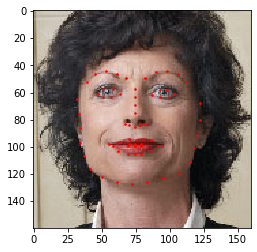

In [10]:
def show_landmarks(image,landmarks): # ランドマークと共に画像を表示する関数
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1],s=10,marker=".",c="r")
    plt.pause(0.001) # ちょっとだけ待機することで、プロットが更新されるのを確実に
    
plt.figure()
show_landmarks(io.imread(os.path.join("./../data/faces/",img_name)),landmarks) # 画像を表示
plt.show()

# Dataset

torch.utils.data.Datasetはデータセットを表すクラスです。自作する際は、必ずDatasetを継承し、さらにしたのメソッドをオーバーライドする必要があります。  
<ul>
    <li>__len__: len(dataset)を実行した際にデータセットのサイズを返す。</li>
    <li>__getitem__: dataset[i]を実行した際に要素を返す。</li>
</ul>

それでは、今回の顔のランドマークのデータセットについてDatasetクラスを作りましょう。  
__init__でcsvを読み込み、__getitem__で画像を読み込みます。  
こうするとメモリを節約できます。  
我々のサンプルでは{"image":image,"landmarks":landmarks}の形式で入っています。  
ここでtransformという任意の引数を受けられるようにすることで、サンプルに対して任意の変換をできます。次のセクションでtransformの有用性を見ます。

In [11]:
class FaceLandmarksDataset(Dataset): # 顔のランドマークのデータセット
    def __init__(self,csv_file,root_dir,transform=None):
        # csv_file: csvファイルのパス
        # root_dir: 全ての画像のディレクトリ 
        # transform: 前処理
        self.landmarks_frame=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx): # インデックスがテンソルの場合
            idx=idx.tolist() # リストに変換
            
        img_name=os.path.join(self.root_dir,self.landmarks_frame.iloc[idx,0])
        image=io.imread(img_name)
        landmarks=self.landmarks_frame.iloc[idx,1:]
        landmarks=np.array([landmarks])
        landmarks=landmarks.astype("float").reshape(-1,2)
        sample={"image":image,"landmarks":landmarks}
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample

それでは最初の4つのサンプルの画像とランドマークを表示してみます。

0 (324, 215, 3) (68, 2)


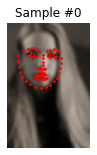

1 (500, 333, 3) (68, 2)


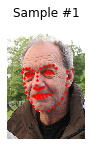

2 (250, 258, 3) (68, 2)


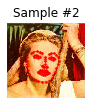

3 (434, 290, 3) (68, 2)


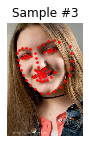

In [18]:
face_dataset=FaceLandmarksDataset(
    csv_file="./../data/faces/face_landmarks.csv",
    root_dir="./../data/faces/"
) # データセットのDatasetクラス化

fig=plt.figure()

for i in range(len(face_dataset)):
    sample=face_dataset[i] # サンプルを取得
    
    print(i,sample["image"].shape,sample["landmarks"].shape)
    
    ### プロットする
    ax=plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)
    
    if i==3: # 4つ目までにしておく
        plt.show()
        break

# Transforms

上で見たものの問題点は、サンプルが全て同じサイズを持っているわけではない、ということです。  
大抵のニューラルネットワークはサンプルは同じサイズを受け付けます。  
なので、ここでは画像のサイズを変更する必要があります。下のような感じです。  
<ul>
    <li>Rescale: 画像のスケールを変更する。</li>
    <li>RandomCrop: 画像から一部をランダムに切り出す。</li>
    <li>ToTensor: numpyの画像をtorchに変換する。軸を変更する必要がある。</li>
</ul>
これらを実行可能な形で実装しておきます。__call__と__init__を用意しておきます。

In [ ]:
### 疑似コード
tsfm=Transform(params)
transformed_sample=tsfm(sample)

画像とランドマークの両方に下のような処理をします。

In [21]:
class Rescale(object): # 画像のサイズを変更する
    def __init__(self,output_size):
        # output_size: 望ましい出力のサイズ。tupleで与えると、そのサイズに変更する。
        # intの場合、比率を保ちながら短い方の辺をその長さにする。
        assert isinstance(output_size,(int,tuple))
        self.output_size=output_size
        
    def __call__(self,sample):
        image,landmarks=sample["image"],sample["landmarks"]
        h,w=image.shape[:2] # 画像のサイズ
        
        if isinstance(self.output_size,int): # intの場合
            if h>w: # 縦長の場合
                new_h,new_w=self.output_size*h/w,self.output_size
            else: # 横長の場合
                new_h,new_w=self.output_size,self.output_size*w/h
        else: # tupleの場合
            new_h,new_w=self.output_size
            
        new_h,new_w=int(new_h),int(new_w)
        img=transform.resize(image,(new_h,new_w))
        
        # ランドマークのためにhとwをスワップする
        # xが第1、yが第0軸
        landmarks=landmarks*[new_w/w,new_h/h]
        
        return {"image":img,"landmarks":landmarks}
    
class RandomCrop(object): # 画像の一部を切り取る
    def __init__(self,output_size):
        assert isinstance(output_size,(int,tuple))
        
        if isinstance(output_size,int): # intの場合
            self.output_size=(output_size,output_size)
        else: # tupleの場合
            assert len(output_size)==2
            self.output_size=output_size
            
    def __call__(self,sample):
        image,landmarks=sample["image"],sample["landmarks"]
        
        h,w=image.shape[:2]
        new_h,new_w=self.output_size
        
        top=np.random.randint(0,h-new_h) # 上辺
        left=np.random.randint(0,w-new_w) # 左辺
        image=image[top:top+new_h,left:left+new_w] # 画像を切り取る
        landmarks=landmarks-[left,top] # ランドマークを切り取る
        
        return {"image":image,"landmarks":landmarks}
    
class ToTensor(object): # テンソルに変換する
    def __call__(self,sample):
        image,landmarks=sample["image"],sample["landmarks"]
        
        # 軸を変更する
        # numpy: (H,W,C)
        # torch: (C,H,W)
        image=image.transpose((2,0,1)) # 軸を変更する
        
        return {"image":torch.from_numpy(image),"landmarks":torch.from_numpy(landmarks)}

それでは実際に変換してみましょう。

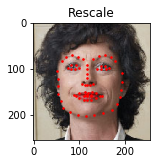

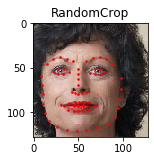

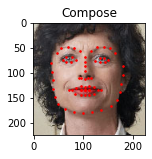

In [23]:
scale=Rescale(256) # 短い方の辺を256に変更する
crop=RandomCrop(128) # (128,128)を切り取る
composed=transforms.Compose([Rescale(256),RandomCrop(224)]) # scale+crop

### 変換して画像を表示する
fig=plt.figure()
sample=face_dataset[65]

for i,tsfrm in enumerate([scale,crop,composed]): # それぞれを実行
    transformed_sample=tsfrm(sample) # 変換する
    
    ax=plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

# データセット全体

毎回、これらの画像は以下のような処理がなされます。  
<ul>
    <li>ファイルから画像を読み込む。</li>
    <li>読み込んだ画像に変換を施す。</li>
    <li>今回は切り取りをランダムにしているので、これをサンプリングとみなせる。</li>
</ul>
これでデータセットについて繰り返せます。

In [24]:
transformed_dataset=FaceLandmarksDataset(
    csv_file="./../data/faces/face_landmarks.csv",
    root_dir="./../data/faces/",
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()
    ])
)

### データセット全体について繰り返す
for i in range(len(transformed_dataset)):
    sample=transformed_dataset[i]
    print(i,sample["image"].size(),sample["landmarks"].size())
    
    if i==3: # 4つ目まで
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


確かにサイズを揃えることができました。  
ただ、多くの情報が失われてしまいました。具体的に以下の通りです。  
<ul>
    <li>データからバッチを取り出す。</li>
    <li>データをシャッフルする。</li>
    <li>multiprocessingを使うことでパラレルでデータを読み出す。</li>
</ul>
torch.utils.data.DataLoaderでこれらをできます。パラメータとしてcollate_fnがあります。バッチでどのようにサンプルが必要なのかをこれで指定します。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


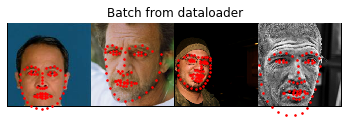

In [25]:
dataloader=DataLoader(
    transformed_dataset, # データセット
    batch_size=4, # バッチサイズ
    shuffle=True, # シャッフル
    num_workers=4
)

def show_landmarks_batch(sample_batched):
    # バッチ分、画像をランドマーク付きで表示する
    images_batch,landmarks_batch=sample_batched["image"],sample_batched["landmarks"]
    batch_size=len(images_batch) # バッチサイズ
    im_size=images_batch.size(2)
    grid_border_size=2
    
    grid=utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size): # バッチ中の各サンプルについて
        plt.scatter(
            landmarks_batch[i,:,0].numpy()+i*im_size+(i+1)*grid_border_size,
            landmarks_batch[i,:,1].numpy()+grid_border_size,
            s=10,
            marker=".",
            c="r"
        )
        plt.title("Batch from dataloader")
        
for i_batch,sample_batched in enumerate(dataloader):
    print(i_batch,sample_batched["image"].size(),sample_batched["landmarks"].size())
    
    # 4番目まで
    if i_batch==3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis("off")
        plt.ioff()
        plt.show()
        
        break

# torchvision

このチュートリアルでは、datasets,transformsとdataloaderの使い方を見てきました。  
torchvisionには一般的なデータセットと変換が入っています。  
例えばImageFolderというのがあります。"ants","bees"というクラスラベルがあります。PIL.Imageのように働くRandomHorizontalFlip,Scaleが使えます。  

In [ ]:
import torch
from torchvision import transforms,datasets

data_transform=transforms.Compose(
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
)
hymenoptera_dataset=datasets.ImageFolder(root="./../data/htmenoptera_data/train",transform=data_transform)
dataset_loader=torch.utils.data.DataLoader(hymenoptera_dataset,batch_size=4,shuffle=True,num_workers=4)